In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
# inspector.get_table_names()

In [12]:
# get list of column names and types
m_columns = inspector.get_columns('measurement')
for c in m_columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# get list of column names and types
s_columns = inspector.get_columns('station')
for c in s_columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column

lastestmeasurement = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
twelveMonthsAgo = dt.date(2017, 8, 23) - dt.timedelta(days=365)

lastyearofdata = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > twelveMonthsAgo).\
    order_by(Measurement.date.desc()).statement

lastyearofdata_df = pd.read_sql_query(lastyearofdata, session.bind)

lastyearofdata_df = lastyearofdata_df.set_index('date')
# lastyearofdata_df = lastyearofdata_df.dropna()

lastyearofdata_df.head()


,prcp
date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00


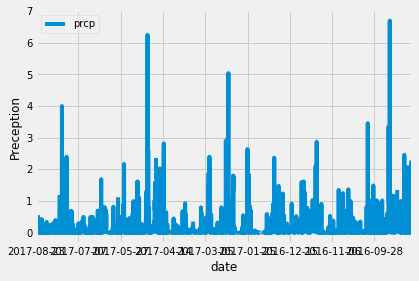

In [120]:
# Use Pandas Plotting with Matplotlib to plot the data

# I just want xaxis to have year and month
# plt.figsize(10,8)
prcp_plot = lastyearofdata_df.plot()
plt.ylabel("Preception")
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
lastyearofdata_df['prcp'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [17]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).\
    group_by(Station.station).count()
print(f"There are {stations} stations available.")

stations = session.query(Station)

There are 9 stations available.


In [103]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()    

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [113]:
# get the most active station

active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).first()

station = [station for station in active_station][0]
station

'USC00519281'

In [114]:
print(f"The most active sation is station ID: {station}")

The most active sation is station ID: USC00519281


In [115]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# answer: [(54.0, 85.0, 71.66378066378067)]

sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

session.query(*sel).\
    filter(Measurement.station == station).all()


[(54.0, 85.0, 71.66378066378067)]

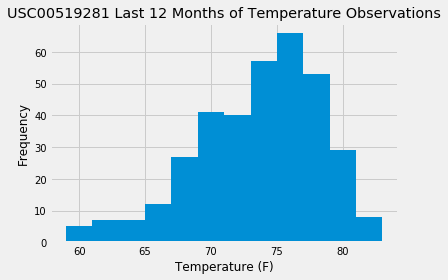

In [117]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_obser_data = session.query(Measurement.tobs).\
    filter(Measurement.station == station).\
    filter(Measurement.date >= twelveMonthsAgo).all()

temp_obser_data_list = [tob[0] for tob in temp_obser_data]
temp_obser_data_list

tops_plot = plt.hist(temp_obser_data_list, bins=12) 
plt.ylim(top=69)
plt.rcParams.update({'font.size': 10})
plt.xlabel("Temperature (F)")
plt.rcParams.update({'font.size': 10})
plt.ylabel("Frequency")
plt.rcParams.update({'font.size': 10})
plt.title(f"{station} Last 12 Months of Temperature Observations")
plt.tight_layout()
plt.show()

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2013-09-02', '2013-09-12'))
trip_temp = calc_temps('2013-09-02', '2013-09-12')
trip_temp_df = pd.DataFrame(trip_temp, columns = ['Trip Min Temp (F)', 'Trip Average Temp (F)', 'Trip Max Temp (F)'])
trip_temp_df

[(66.0, 75.24418604651163, 81.0)]


,Trip Min Temp (F),Trip Average Temp (F),Trip Max Temp (F)
0,66.0,75.244186,81.0


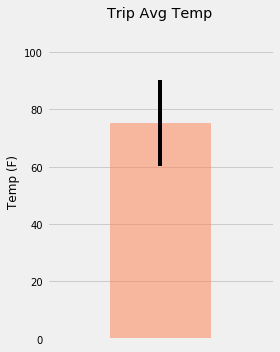

In [66]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

yerr = trip_temp_df.iloc[0,2] - trip_temp_df.iloc[0,0]
trip_temp_plot = trip_temp_df.plot(y='Trip Average Temp (F)', kind='bar', yerr=yerr, legend=False, width=.4, 
                                   figsize=(4,5), color='coral', alpha=.5)
plt.xticks([])
plt.ylim(top=110) 
plt.rcParams.update({'font.size': 10})
plt.title("Trip Avg Temp")
plt.rcParams.update({'font.size': 10})
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.show()

##### Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

station_by_station = session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= '2013-09-02').\
    filter(Measurement.date <= '2013-09-12').\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).statement

station_by_station_df = pd.read_sql_query(station_by_station, session.bind)
station_by_station_df = station_by_station_df.rename(columns={'sum_1':'sum of rainfall'})
station_by_station_df

## Optional Challenge Assignment

In [130]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [149]:
from itertools import chain

# Set the start and end date of the trip

# from datetime import datetime

start_date = ('2013-09-02')
end_date = ('2013-09-12')

# Use the start and end date to create a range of dates

date_range = pd.date_range(start_date, end_date)

# Stip off the year and save a list of %m-%d strings

date_stripped = date_range.strftime("%m-%d")

# Loop through the list of %m-%d strings and calculate the normals for each date
# calculate the daily normals for your trip

daily_normal=[]
for day in date_stripped:
    daily_normal.append(daily_normals(day))

# push each tuple of calculations into a list called `normals`

normal = [day for day in chain.from_iterable(daily_normal)]
normals = [list(x) for x in normal]

normals

[[67.0, 76.66666666666667, 83.0],
 [69.0, 76.13725490196079, 83.0],
 [68.0, 76.27083333333333, 84.0],
 [66.0, 75.91489361702128, 84.0],
 [66.0, 74.91111111111111, 81.0],
 [64.0, 75.18, 82.0],
 [66.0, 76.22222222222223, 83.0],
 [68.0, 76.36538461538461, 84.0],
 [67.0, 76.61224489795919, 85.0],
 [70.0, 76.69565217391305, 83.0],
 [68.0, 75.89795918367346, 85.0]]

In [150]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame(normals, index=date_range, columns=['TMIN', 'TAVG', 'TMAX'])
daily_normals_df

,TMIN,TAVG,TMAX
2013-09-02,67.0,76.666667,83.0
2013-09-03,69.0,76.137255,83.0
2013-09-04,68.0,76.270833,84.0
2013-09-05,66.0,75.914894,84.0
2013-09-06,66.0,74.911111,81.0
2013-09-07,64.0,75.180000,82.0
2013-09-08,66.0,76.222222,83.0
2013-09-09,68.0,76.365385,84.0
2013-09-10,67.0,76.612245,85.0
2013-09-11,70.0,76.695652,83.0


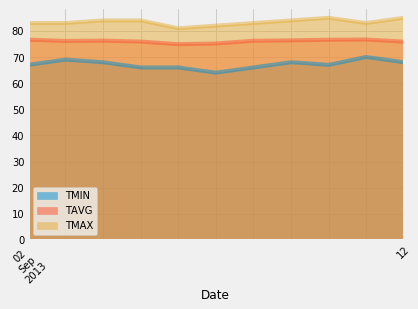

In [163]:
# Plot the daily normals as an area plot with `stacked=False`

daily_normals_df.plot(kind='area', stacked=False, grid=True, legend=True, rot=45, xticks=date_range)
plt.xlabel("Date")
plt.show()